In [1]:
import numpy as np
from pathlib import Path
from powm.envs.mordor import MordorHike
from dreamerv3 import embodied


logdir = Path("/home/sai/Desktop/powm/experiments/train_dreamer")
config = embodied.Config.load(str(logdir / "config.yaml"))

In [2]:
episodes = np.load(logdir / "episodes_50000.npz", allow_pickle=True)

In [3]:
# Divide the episodes into train, val, test as 80%, 10%, 10%
train_episodes = episodes["episodes"][:int(0.8 * len(episodes["episodes"]))]
val_episodes = episodes["episodes"][int(0.8 * len(episodes["episodes"])):int(0.9 * len(episodes["episodes"]))]
test_episodes = episodes["episodes"][int(0.9 * len(episodes["episodes"])):]


In [4]:
# any difficulty is fine as we use it primarily for visualization
# But ideally we have to read the config and create the environment accordingly
env = MordorHike.medium(render_mode="human", estimate_belief=True)

In [5]:
def make_dataset(episodes):
    episode_id = 0
    X, Y = [], []
    for episode_id in range(len(episodes)):
        episode = episodes[episode_id]
        episode["true_belief"] = []
        step = 0
        for step in range(len(episode["belief"])):
            discretized_belief = env.discretize_belief(episode["belief"][step])
            episode["true_belief"].append(discretized_belief)
            latent = episode["latents"][step]
            x = latent.reshape(-1)
            y = discretized_belief.reshape(-1)
            X.append(x)
            Y.append(y)
        episode["true_belief"] = np.array(episode["true_belief"])
    return X, Y

train_X, train_Y = make_dataset(train_episodes)
val_X, val_Y = make_dataset(val_episodes)
test_X, test_Y = make_dataset(test_episodes)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert to tensors
train_X = torch.FloatTensor(train_X)
train_Y = torch.FloatTensor(train_Y)
val_X = torch.FloatTensor(val_X)
val_Y = torch.FloatTensor(val_Y)
test_X = torch.FloatTensor(test_X)
test_Y = torch.FloatTensor(test_Y)

# Create model
class BeliefPredictor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            # nn.ReLU(),
            # nn.Linear(256, 128),
            # nn.ReLU(),
            # nn.Linear(128, output_dim),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.network(x)

# Training setup
model = BeliefPredictor(train_X.shape[1], train_Y.shape[1])
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.KLDivLoss(reduction='batchmean')  # Good for probability distributions
dataset = TensorDataset(train_X, train_Y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Training loop
best_model = None
best_val_loss = float('inf')

for epoch in range(100):
    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        pred = model(batch_x)
        loss = criterion(pred.log(), batch_y)
        loss.backward()
        optimizer.step()
    # validate on val set
    val_pred = model(val_X)
    val_loss = criterion(val_pred.log(), val_Y)
    print(f"Epoch {epoch}, Val Loss: {val_loss.item()}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model



/tmp/ipykernel_64871/14215700.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  train_X = torch.FloatTensor(train_X)


Epoch 0, Val Loss: 2.1784708499908447
Epoch 1, Val Loss: 1.868590235710144
Epoch 2, Val Loss: 1.6776070594787598
Epoch 3, Val Loss: 1.5775988101959229
Epoch 4, Val Loss: 1.4895529747009277
Epoch 5, Val Loss: 1.4342836141586304
Epoch 6, Val Loss: 1.3710689544677734
Epoch 7, Val Loss: 1.334904670715332
Epoch 8, Val Loss: 1.2922356128692627
Epoch 9, Val Loss: 1.2737486362457275
Epoch 10, Val Loss: 1.2338510751724243
Epoch 11, Val Loss: 1.222019910812378
Epoch 12, Val Loss: 1.2098212242126465
Epoch 13, Val Loss: 1.1840044260025024
Epoch 14, Val Loss: 1.1868033409118652
Epoch 15, Val Loss: 1.1571403741836548
Epoch 16, Val Loss: 1.1405706405639648
Epoch 17, Val Loss: 1.139724850654602
Epoch 18, Val Loss: 1.1275709867477417
Epoch 19, Val Loss: 1.1203173398971558
Epoch 20, Val Loss: 1.114253282546997
Epoch 21, Val Loss: 1.095212697982788
Epoch 22, Val Loss: 1.093809723854065
Epoch 23, Val Loss: 1.0823822021484375
Epoch 24, Val Loss: 1.0871633291244507
Epoch 25, Val Loss: 1.084153413772583
Epoc

In [7]:
best_model.eval()
with torch.no_grad():
    test_pred = best_model(test_X)
    train_pred = best_model(train_X)
    val_pred = best_model(val_X)
overall_kldiv = criterion(test_pred.log(), test_Y).detach().numpy().item()
episodic_scores = []
episodic_kldiv = []
idx = 0
for episode in test_episodes:
    
    
    end_idx = idx + len(episode["belief"])
    episode["predicted_belief"] = test_pred[idx:end_idx].reshape(-1, 20, 20).detach().numpy()
    #episode["true_belief"] = test_Y[idx:end_idx].reshape(-1, 20, 20).detach().numpy()
    episodic_kl_div = criterion(test_pred[idx:end_idx].log(), test_Y[idx:end_idx]).detach().numpy().item()
    episodic_score = episode["reward"].sum()
    episodic_scores.append(episodic_score)
    episodic_kldiv.append(episodic_kl_div)
    
    idx = end_idx



# Pearson correlation coefficient between episodic scores and kldiv

from scipy.stats import pearsonr
episodic_correlation = pearsonr(episodic_scores, episodic_kldiv)


In [11]:
idx = 0
for episode in train_episodes:
    end_idx = idx + len(episode["belief"])
    episode["predicted_belief"] = train_pred[idx:end_idx].reshape(-1, 20, 20).detach().numpy()
    idx = end_idx

In [12]:
overall_kldiv, episodic_correlation

(0.6666422486305237,
 PearsonRResult(statistic=0.29372960795380243, pvalue=0.38065327631370866))

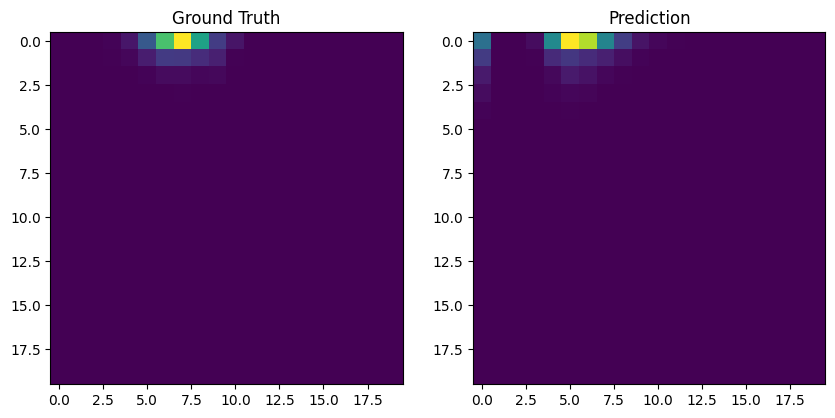

In [13]:
import matplotlib.pyplot as plt
# plot the ground truth and prediction belief histogram side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
time_idx = 25
axs[0].imshow(test_episodes[0]["true_belief"][time_idx])
axs[0].set_title("Ground Truth")
axs[1].imshow(test_episodes[0]["predicted_belief"][time_idx])
axs[1].set_title("Prediction")
plt.show()


In [33]:
import cv2


def visualize_trajectory_step(env, episode, step_idx):
    """
    Visualize a single step showing true and predicted belief distributions side by side
    """
    # Get true and predicted belief grids
    true_grid = episode['true_belief'][step_idx]
    pred_grid = episode['predicted_belief'][step_idx]

    # Normalize grids to 0-255 range
    true_grid = (((true_grid - true_grid.min()) / (true_grid.max() - true_grid.min())) * 255).astype(np.uint8)
    pred_grid = (((pred_grid - pred_grid.min()) / (pred_grid.max() - pred_grid.min())) * 255).astype(np.uint8)
    # Make y coordinates to be negative 
    true_grid = np.flip(true_grid, axis=1).T
    pred_grid = np.flip(pred_grid, axis=1).T
    
    render_size = (256, 256)
    # resize the grids to match the image size
    true_grid = cv2.resize(true_grid, render_size)
    pred_grid = cv2.resize(pred_grid, render_size)
    
    
    
    # Create two backgrounds
    env.render_size = render_size  # Increased size for better visibility
    true_img = env._create_background()
    pred_img = true_img.copy()
    h, w = true_img.shape[:2]
    
    # Convert belief grids to heatmaps
    true_heatmap = cv2.applyColorMap(
        (true_grid * 255).astype(np.uint8), 
        cv2.COLORMAP_JET
    )
    pred_heatmap = cv2.applyColorMap(
        (pred_grid * 255).astype(np.uint8), 
        cv2.COLORMAP_JET
    )
    
    # Blend heatmaps with background
    alpha = 0.33
    true_vis = cv2.addWeighted(true_img, 1-alpha, true_heatmap, alpha, 0)
    pred_vis = cv2.addWeighted(pred_img, 1-alpha, pred_heatmap, alpha, 0)
    
    # Draw path and current position
    path = episode['state'][:step_idx+1, :2]
    current_state = episode['state'][step_idx]
    path_pixels = env._world_to_pixel(path)
    pos_pixel = env._world_to_pixel(current_state[:2])
    
    # Draw path
    for img in [true_vis, pred_vis]:
        cv2.polylines(img, [path_pixels.astype(np.int32)], False, (0, 0, 255), 2)
        # Draw current position as red circle
        cv2.circle(img, tuple(pos_pixel.astype(np.int32)), 5, (0, 0, 255), -1)
    
    # Stack images side by side
    combined = np.hstack([true_vis, pred_vis])
    
    # Add labels and colorbar
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(combined, "True Belief", (10, 30), font, 1, (255, 255, 255), 2)
    cv2.putText(combined, "Predicted Belief", (w + 10, 30), font, 1, (255, 255, 255), 2)
    
    # Add colorbar
    colorbar_h = 20
    colorbar = np.linspace(0, 255, w).astype(np.uint8)
    colorbar = cv2.applyColorMap(colorbar.reshape(1, -1), cv2.COLORMAP_JET)
    colorbar = cv2.resize(colorbar, (w*2, colorbar_h))
    
    # Add min/max labels to colorbar
    cv2.putText(colorbar, "0.0", (5, 15), font, 0.1, (255, 255, 255), 1)
    cv2.putText(colorbar, "1.0", (w*2-30, 15), font, 0.1, (255, 255, 255), 1)
    
    # Combine visualization with colorbar
    combined = np.vstack([combined, colorbar])
    
    return combined
episode = test_episodes[7]
frames = []
for i in range(len(episode['state'])):
    frame = visualize_trajectory_step(env, episode, step_idx=i)
    frames.append(frame)
    cv2.imshow('Trajectory Visualization', frame)
    cv2.waitKey(100)  # 50ms delay between frames
cv2.destroyAllWindows()

import imageio
imageio.mimsave('trajectory.gif', frames, fps=10)

